In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/pippahtlin/Extreme-Precipitation/main/data/precipitation_soi",index_col = "date")
df

,year,month,day,daily rain,binary rain,soi
date,,,,,,
1899-10-11,1899,10,11,3.048000,0,-1
1899-10-12,1899,10,12,2.032000,0,-1
1899-10-13,1899,10,13,33.020000,1,-1
1899-10-14,1899,10,14,0.508000,0,-1
1899-10-15,1899,10,15,0.000000,0,-1
...,...,...,...,...,...,...
2022-12-27,2022,12,27,0.000000,0,1
2022-12-28,2022,12,28,22.859999,0,1
2022-12-29,2022,12,29,0.000000,0,1


<br>

## 1. EDA

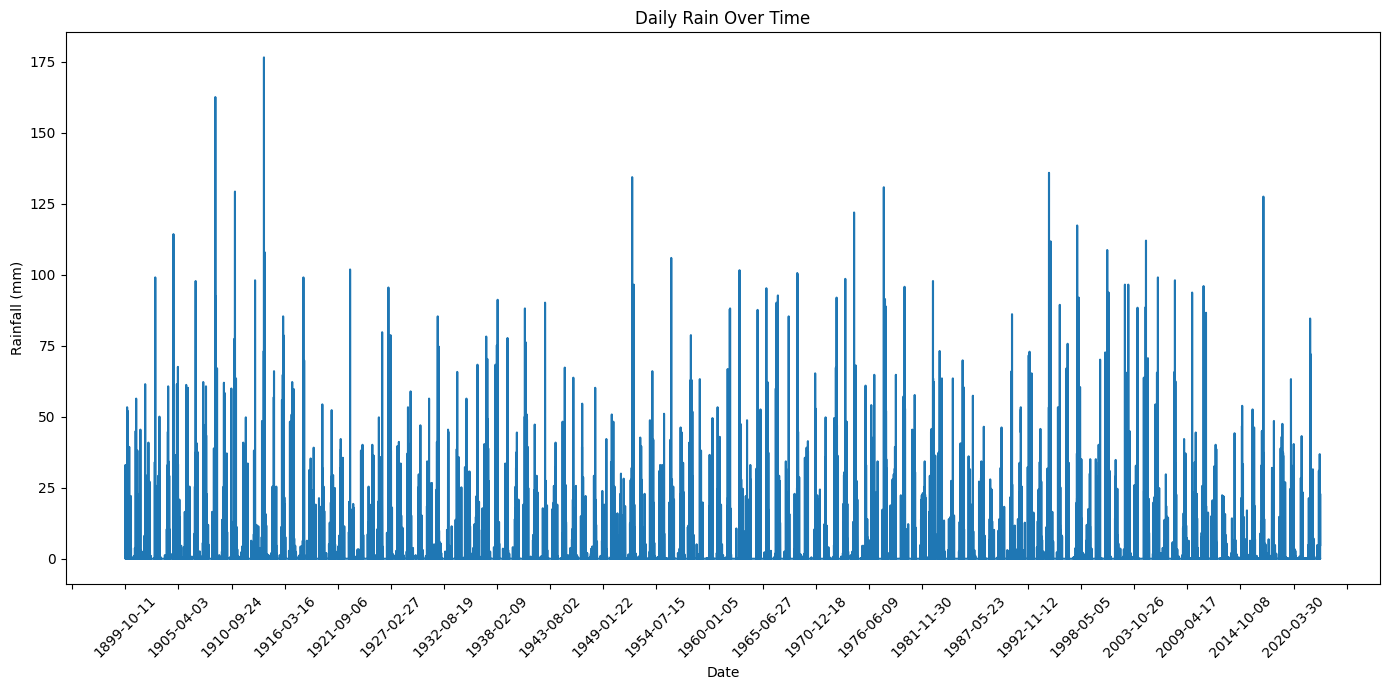

In [5]:
plt.figure(figsize=(14, 7))
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=30))

plt.plot(df.index,df['daily rain'],label = 'Daily Rain')
plt.title('Daily Rain Over Time')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.tight_layout()
plt.show()

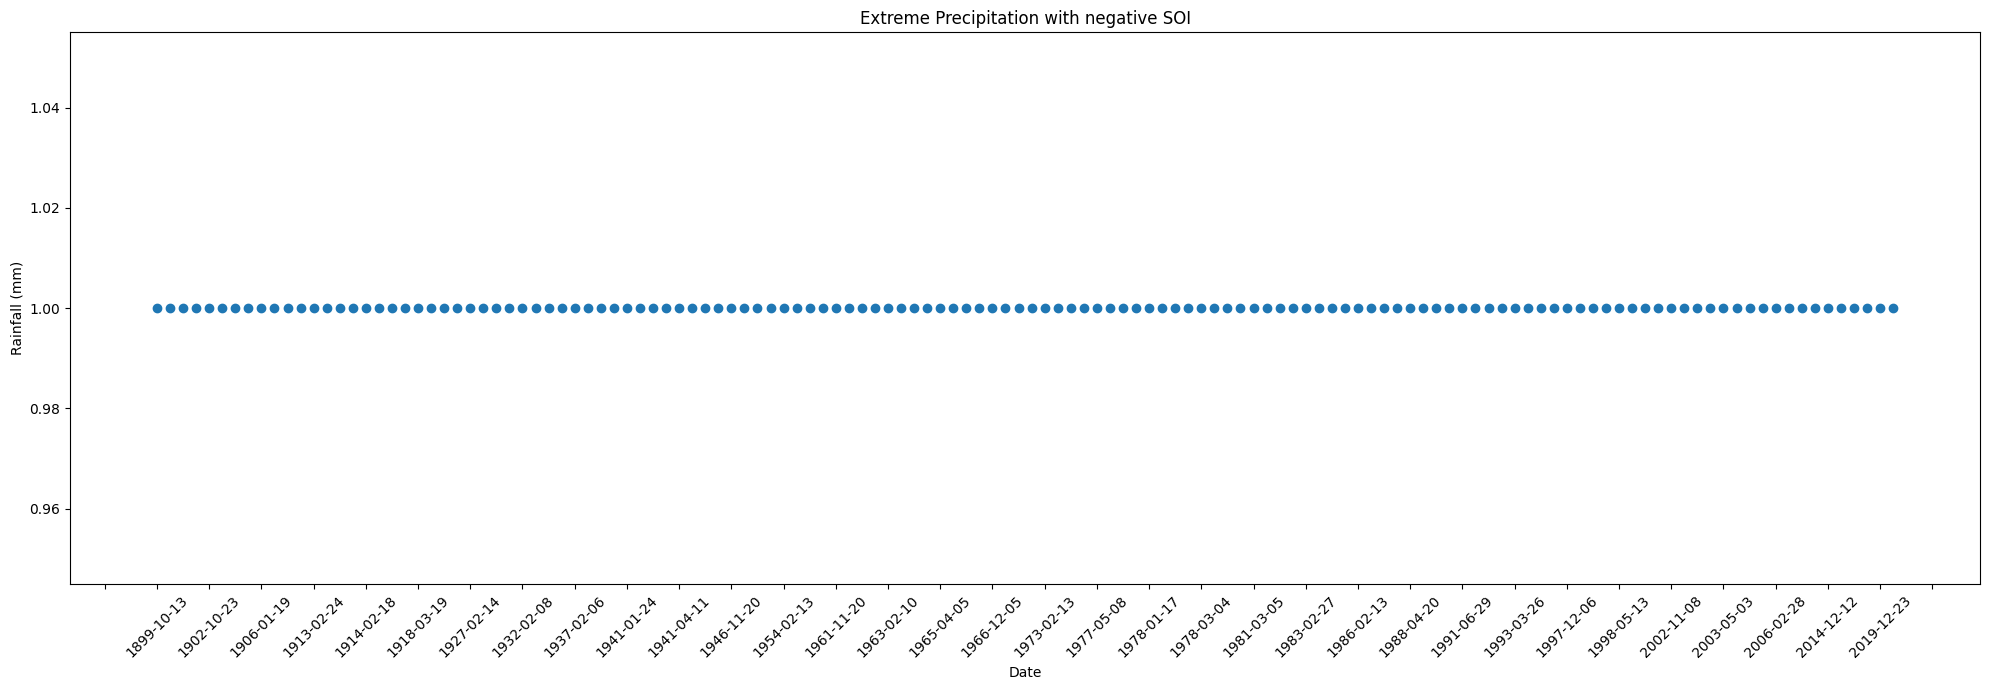

In [6]:
plt.figure(figsize=(20, 7))
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=40))

plt.plot(df[(df['soi'] == -1) & (df['binary rain'] == 1)].index, df[(df['soi'] == -1) & (df['binary rain'] == 1)]['binary rain'],'o',label = 'Extreme Precipitation')
plt.title('Extreme Precipitation with negative SOI')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.tight_layout()
plt.show()

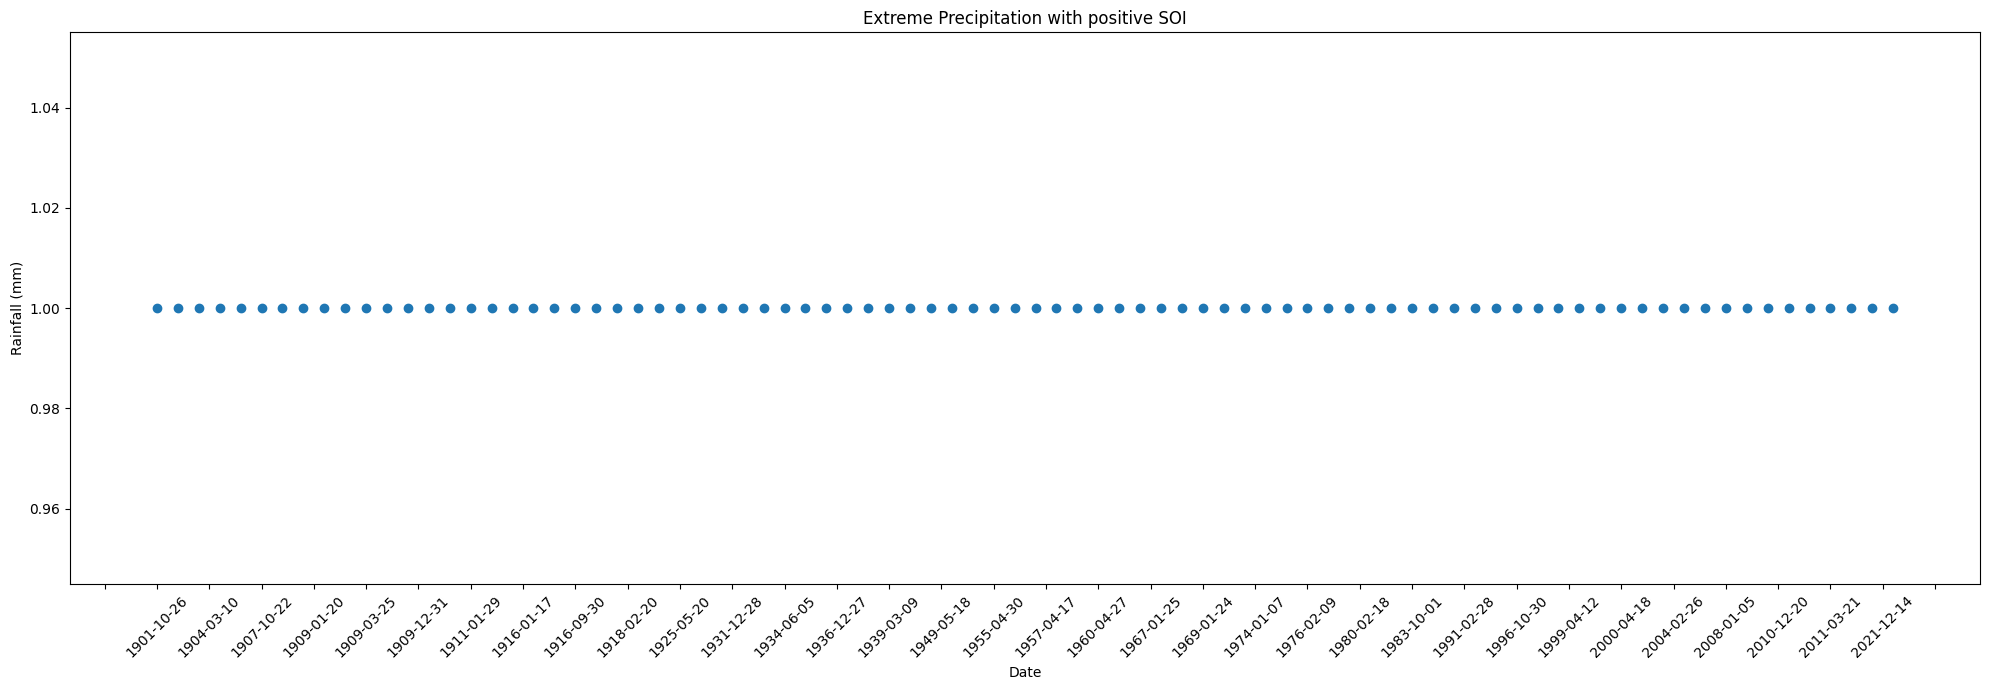

In [7]:
plt.figure(figsize=(20, 7))
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=40))

plt.plot(df[(df['soi'] == 1) & (df['binary rain'] == 1)].index, df[(df['soi'] == 1) & (df['binary rain'] == 1)]['binary rain'],'o',label = 'Extreme Precipitation')
plt.title('Extreme Precipitation with positive SOI')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.tight_layout()
plt.show()

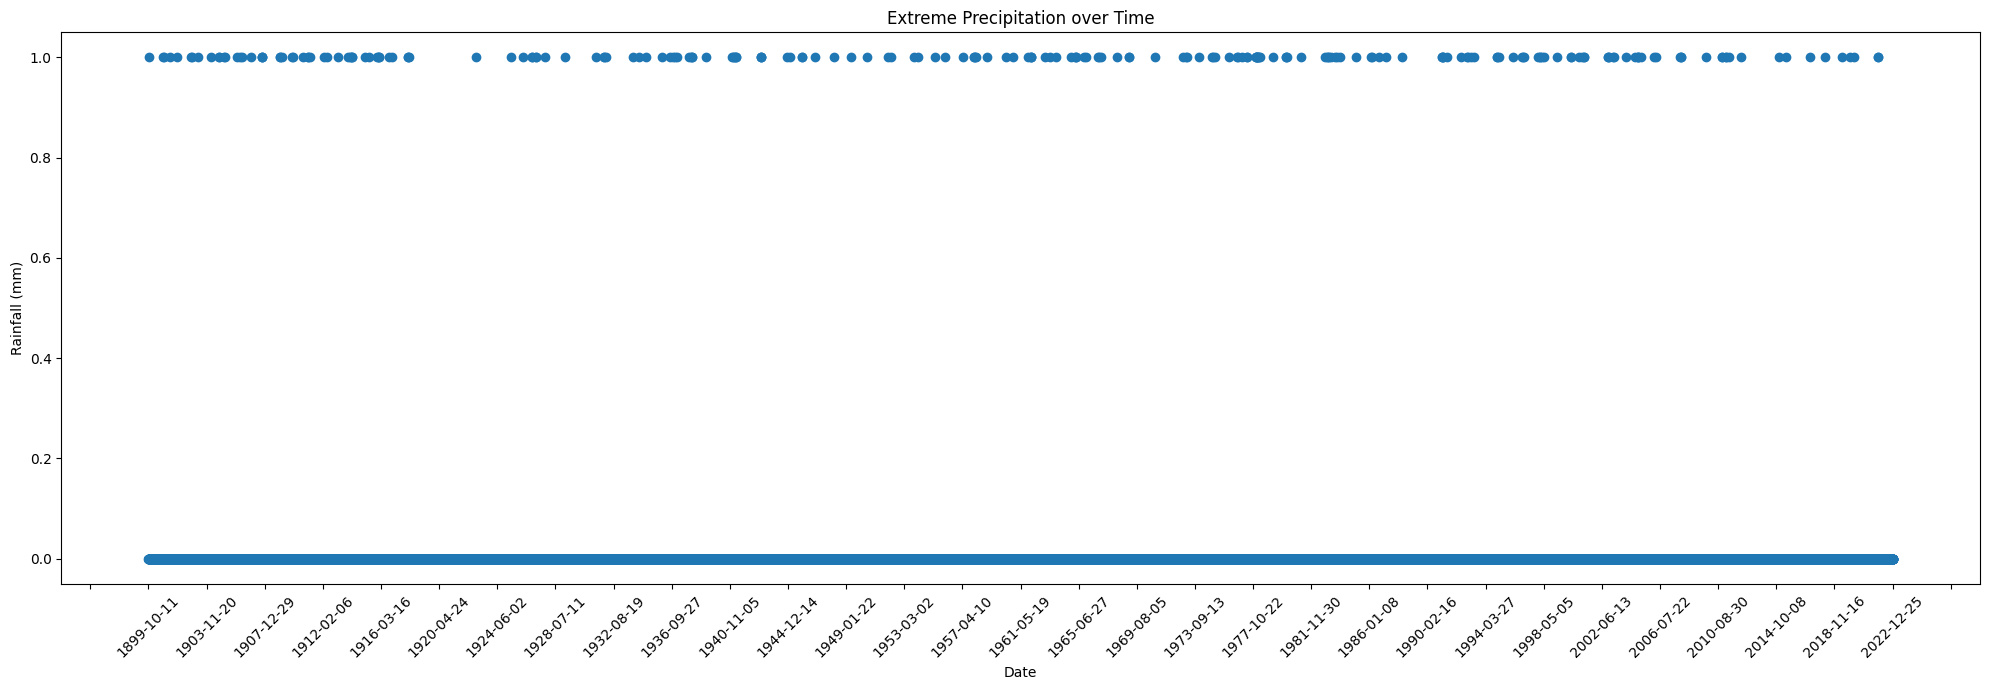

In [8]:
plt.figure(figsize=(20, 7))
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=40))

plt.plot(df.index, df['binary rain'], 'o', label = 'Extreme Precipitation')
plt.title('Extreme Precipitation over Time')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.tight_layout()
plt.show()

<br>

## 2. Split Data
Training set: 60% | Validation set: 20% | Testing set: 20%

In [9]:
# Calculate indices for splitting
total_rows = len(df)
train_end = int(total_rows * 0.6)
validation_end = train_end + int(total_rows * 0.2)

# Using iloc for integer-location based indexing
train_features = df["soi"].iloc[:train_end]
train_rain = df.iloc[:train_end]['binary rain']

validation_features = df["soi"].iloc[train_end:validation_end]
validation_rain = df.iloc[train_end:validation_end]['binary rain']

test_features = df["soi"].iloc[validation_end:]
test_rain = df.iloc[validation_end:]['binary rain']

In [10]:
T = 90 # Consider seasonality

# Prepend the last T-1 observations from the training set to the validation features
prepend_features_to_validation = train_features.iloc[-(T-1):]
validation_features = pd.concat([prepend_features_to_validation, validation_features], axis=0)

# Similarly, prepend the last T-1 observations from the validation set (including the part that was just prepended) to the test features
prepend_features_to_test = validation_features.iloc[-(T-1):]
test_features = pd.concat([prepend_features_to_test, test_features], axis=0)

# Output the shapes of the datasets to check everything is as expected
train_features.shape, train_rain.shape, validation_features.shape, validation_rain.shape, test_features.shape, test_rain.shape

((27004,), (27004,), (9090,), (9001,), (9091,), (9002,))

<br>

## 3. Data Preprocessing

Input data for the Keras LSTM layer has 3 dimensions: (M, T, N), where
* M - number of examples (2D: sequences of timesteps x features),
* T - sequence length (timesteps) and
* N - number of features (input_dim)

In [28]:
# Create sequences of T timesteps
X_train, y_train = [], []
for i in range(len(train_rain) - (T-1)):
    X_train.append(train_features.iloc[i:i+T].values)
    y_train.append(train_rain.iloc[i + (T-1)])

X_train, y_train = np.array(X_train), np.array(y_train).reshape(-1,1) # Reshape to vector for model
X_train = X_train[:, :, np.newaxis]
print(f'Train data dimensions: {X_train.shape}, {y_train.shape}')


X_val, y_val = [], []
for i in range(len(validation_rain) - (T-1)):
    X_val.append(validation_features.iloc[i:i+T].values)
    y_val.append(validation_rain.iloc[i + (T-1)])
X_val, y_val = np.array(X_val), np.array(y_val).reshape(-1,1)
X_val = X_val[:, :, np.newaxis]
print(f'Validation data dimensions: {X_val.shape}, {y_val.shape}')

X_test, y_test = [], []
for i in range(len(test_rain)):
    X_test.append(test_features.iloc[i:i+T].values)
    y_test.append(test_rain.iloc[i])
X_test, y_test = np.array(X_test), np.array(y_test).reshape(-1,1)
X_test = X_test[:, :, np.newaxis]

print(f'Test data dimensions: {X_test.shape}, {y_test.shape}')

Train data dimensions: (26915, 90, 1), (26915, 1)
Validation data dimensions: (8912, 90, 1), (8912, 1)
Test data dimensions: (9002, 90, 1), (9002, 1)


<br>

## 4. Batch Training and Predictions

In [12]:
# Import Keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from time import time

In [29]:
# 1. Make a list of CONSTANTS for modelling:
LAYERS = [8, 8, 8, 1]                # number of units in hidden and output layers
M_TRAIN = X_train.shape[0]           # number of training examples (2D)
M_VAL = X_val.shape[0]           # number of training examples (2D)
M_TEST = X_test.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train.shape[1]                 # number of features
BATCH = M_TRAIN                          # batch size
EPOCH = 50                           # number of epochs (possible tune)
LR = 5e-2                            # learning rate of the gradient descent (possible tune)
LAMBD = 3e-2                         # lambda in L2 regularizaion (possible tune)
DP = 0.0                             # dropout rate (possible tune)
RDP = 0.0                            # recurrent dropout rate (possible tune)
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')


layers=[8, 8, 8, 1], train_examples=26915, test_examples=9002
batch = 26915, timesteps = 90, features = 90, epochs = 50
lr = 0.05, lambda = 0.03, dropout = 0.0, recurr_dropout = 0.0
